In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
os.environ['KERAS_BACKEND']='tensorflow'
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
embed_file = os.path.join('.', 'Glove', 'glove.6B.50d.txt')
train_file = os.path.join('.', 'train.csv')
test_file = os.path.join('.', 'test.csv')

In [3]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

In [4]:
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values

In [5]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [6]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embed_file, encoding='utf-8'))

In [7]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.020940498, 0.6441043)

In [8]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [9]:
import tensorflow as tf

def roc_auc(y_true, y_pred):
    #print (y_true)
    
    auroc, _= tf.metrics.auc(y_true, y_pred, num_thresholds=500)
    return auroc

In [9]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=()):
        super(Callback, self).__init__()
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.X_val, verbose=0)
        score = roc_auc_score(self.y_val, y_pred)
        print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

X_tra, X_val, y_tra, y_val = train_test_split(X_t, y, train_size=0.9, random_state=6)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [12]:
cp = ModelCheckpoint(filepath="my_model1.h5", save_best_only=True)
es = EarlyStopping()

hist = model.fit(X_tra, y_tra, batch_size = 1024, epochs=5, validation_data=(X_val, y_val), callbacks=[cp, es, RocAuc])

Train on 143613 samples, validate on 15958 samples
Epoch 1/5
143613/143613 [==============================] - 630s 4ms/step - loss: 0.1680 - acc: 0.9532 - val_loss: 0.0667 - val_acc: 0.9768

 ROC-AUC - epoch: 0 - score: 0.953786 

Epoch 2/5
143613/143613 [==============================] - 889s 6ms/step - loss: 0.0624 - acc: 0.9786 - val_loss: 0.0536 - val_acc: 0.9810

 ROC-AUC - epoch: 1 - score: 0.968725 

Epoch 3/5
143613/143613 [==============================] - 924s 6ms/step - loss: 0.0545 - acc: 0.9807 - val_loss: 0.0506 - val_acc: 0.9812

 ROC-AUC - epoch: 2 - score: 0.972381 

Epoch 4/5
143613/143613 [==============================] - 1167s 8ms/step - loss: 0.0507 - acc: 0.9817 - val_loss: 0.0487 - val_acc: 0.9822

 ROC-AUC - epoch: 3 - score: 0.974227 

Epoch 5/5
143613/143613 [==============================] - 991s 7ms/step - loss: 0.0485 - acc: 0.9823 - val_loss: 0.0479 - val_acc: 0.9825

 ROC-AUC - epoch: 4 - score: 0.976246 



{'val_loss': [0.06669487342236559, 0.053558416597368666, 0.05055132243412974, 0.04869893693747654, 0.04785167655719299], 'val_acc': [0.9768349561480326, 0.980991682853596, 0.9812005642422877, 0.9822241093509104, 0.9824747552114526], 'loss': [0.16800999798992272, 0.06240023123368034, 0.05446818407568437, 0.05072730981609803, 0.04854289452054156], 'acc': [0.9531993919265791, 0.9786021458029595, 0.9806852797678391, 0.981691461830955, 0.9823309133254086]}


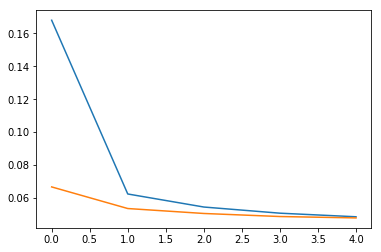

In [16]:
print (hist.history)
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(1)
plt.plot (hist.history['loss'])
plt.plot (hist.history['val_loss'])
#plt.plot (hist.history['RocAus'])

In [13]:
# load the model 载入已经训练好的模型！！！
from keras.models import load_model  
model = load_model("my_model1.h5")

In [14]:
y_pred = model.predict(X_te, batch_size=1024)
submission = pd.read_csv('./sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submission1.csv', index=False)